In [ ]:
!pip install lightgbm

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns

#from scipy.stats import uniform

# from imblearn.under_sampling import RandomUnderSampler

#from sklearn.decomposition import PCA

from sklearn.pipeline import Pipeline

#from sklearn.model_selection import train_test_split

from sklearn.preprocessing import StandardScaler, Binarizer

from sklearn.feature_selection import SelectFromModel

from sklearn.tree import DecisionTreeClassifier

#from sklearn.linear_model import LogisticRegression, Ridge

from sklearn.model_selection import KFold, GridSearchCV, RandomizedSearchCV, cross_val_score

from sklearn.metrics import make_scorer, confusion_matrix, roc_curve, auc, f1_score, accuracy_score, precision_score, recall_score, log_loss

import matplotlib.pyplot as plt

import datetime

import warnings

warnings.filterwarnings('ignore')

#import torch

#from torch.utils.data import DataLoader, TensorDataset

In [10]:
train = pd.read_csv('../dataset_processed/train_538132.csv')
val = pd.read_csv('../dataset_processed/validation_179377.csv')
test = pd.read_csv('../dataset_processed/test_179378.csv')

In [ ]:
X_train = train.drop('depvar', axis=1)
y_train = train['depvar']

X_val = val.drop('depvar', axis=1)
y_val = val['depvar']

X_test = test.drop('depvar', axis=1)
y_test = test['depvar']

In [ ]:
print(X_train.shape)
print(y_train.shape)
print(X_val.shape)
print(y_val.shape)
print(X_test.shape)
print(y_test.shape)

(538132, 86)
(538132,)
(179377, 86)
(179377,)
(179378, 86)
(179378,)


In [ ]:
# Define the pipeline
from lightgbm import LGBMClassifier

lgbm = LGBMClassifier(n_estimators = 150)

evals = [(X_val,y_val)]
lgbm.fit(X_train,y_train, early_stopping_rounds = 100, eval_set = evals,eval_metric = 'logloss',verbose = True)
# pipeline = Pipeline([
#     ('clf', RandomForestClassifier())
# ])

[1]	valid_0's binary_logloss: 0.44081	valid_0's binary_logloss: 0.44081
Training until validation scores don't improve for 100 rounds.
[2]	valid_0's binary_logloss: 0.438857	valid_0's binary_logloss: 0.438857
[3]	valid_0's binary_logloss: 0.437193	valid_0's binary_logloss: 0.437193
[4]	valid_0's binary_logloss: 0.435737	valid_0's binary_logloss: 0.435737
[5]	valid_0's binary_logloss: 0.4345	valid_0's binary_logloss: 0.4345
[6]	valid_0's binary_logloss: 0.433395	valid_0's binary_logloss: 0.433395
[7]	valid_0's binary_logloss: 0.432427	valid_0's binary_logloss: 0.432427
[8]	valid_0's binary_logloss: 0.431609	valid_0's binary_logloss: 0.431609
[9]	valid_0's binary_logloss: 0.430866	valid_0's binary_logloss: 0.430866
[10]	valid_0's binary_logloss: 0.43018	valid_0's binary_logloss: 0.43018
[11]	valid_0's binary_logloss: 0.429501	valid_0's binary_logloss: 0.429501
[12]	valid_0's binary_logloss: 0.42889	valid_0's binary_logloss: 0.42889
[13]	valid_0's binary_logloss: 0.428377	valid_0's binary

LGBMClassifier(n_estimators=150)

In [ ]:
preds_proba = lgbm.predict_proba(X_val)

In [ ]:
preds_proba[:,1]

array([0.30738465, 0.14072509, 0.21546285, ..., 0.13183326, 0.19943453,
       0.18453668])

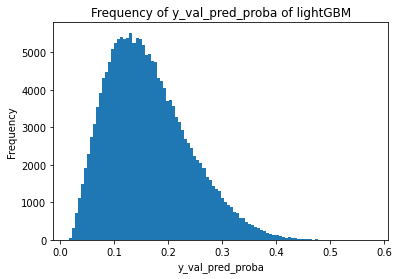

In [ ]:
# Predict probabilities for new data
 # 확률로 추정된 X_val의 y_pred

plt.hist(preds_proba[:,1], bins=100)

plt.xlabel('y_val_pred_proba')
plt.ylabel('Frequency')
plt.title('Frequency of y_val_pred_proba of lightGBM')

#plt.savefig("%s_val_pre_proba_%s.png"%(model_name, datetime.datetime.now().strftime("%m%d%H%M%S")), dpi=300, bbox_inches='tight')

plt.show() # y_val_pred_proba의 분포 확인

### optimal threshold 선정 (threshold에 따른 목적함수 값 비교)

실제 positive = TP + FN

실제 Negative = TN + FP

정밀도: positive로 예측한 것 중에 진짜 positive인 것 -> 양성 예측도

재현율: 실제 positive 중에 맞춘 것 -> 민감도

In [ ]:
threshold_list = np.linspace(0.1,0.18,10) # 짝수개 값 (예시 10개)

In [ ]:
def threshold_func(y_val, y_pred_proba, threshold_list):
    
    n = len(threshold_list)
    
    result_df = pd.DataFrame(index=['1_real','1_pred','0_real','0_pred','tn', 'fp', 'fn', 'tp', 'tn_%', 'fp_%', 'fn_%', 'tp_%', 'Accuracy', 'Precision', 'Recall', 'F1 score'])
    
    fig, axes = plt.subplots(nrows=int(n/2), ncols=2, figsize=(10, 10))
    
    for i in range(len(threshold_list)):
        
        threshold = threshold_list[i]
        
        # make Binarizer(y hat)
        binarizer = Binarizer(threshold = threshold).fit(y_pred_proba[:,1].reshape(-1,1))
        custom_predict = binarizer.transform(y_pred_proba[:,1].reshape(-1,1))
        
        # count 0, 1 in Binarizer(y hat)
        unique, counts = np.unique(custom_predict, return_counts=True)

        for val, count in zip(unique, counts):
            if len(unique) == 1:
                if val == 1.0:
                    num_0_pred = 0
                    num_1_pred = count
                elif val == 0.0:
                    num_1_pred = 0
                    num_0_pred = count
            if val == 1.0:
                num_1_pred = count
            elif val == 0.0:
                num_0_pred = count

        # count 0, 1 in y hat
        num_0_real = y_val.value_counts()[0]
        num_1_real = y_val.value_counts()[1]
        
        tn, fp, fn, tp = confusion_matrix(y_val, custom_predict).ravel()
        count = [tn, fp, fn, tp]
        tn_, fp_, fn_, tp_ = [round(x/sum(count)*100, 1) for x in count]
        
        accuracy = round((tp+tn)/(tp+tn+fp+fn),4)
        precision = round(tp/(tp+fp),4)
        recall = round(tp/(tp+fn),4)
        f1 = round(2*(precision*recall)/(precision+recall),4)
        
        threshold_tag = round(threshold_list[i], 4)
        
        result_df[threshold_tag] = [num_1_real, num_1_pred, num_0_real, num_0_pred, tn, fp, fn, tp, tn_, fp_, fn_, tp_, accuracy, precision, recall, f1]
        
        labels = ['TN','FP','FN','TP']
        
        # tn, fp, fn, tp 각각의 값을 counts 리스트에 저장
        counts = [tn, fp, fn, tp]

        # 해당하는 subplot에 그래프 그리기
        axes[i//2, i%2].bar(labels, counts)
        axes[i//2, i%2].set_title(threshold_tag)
        axes[i//2, i%2].set_ylabel('Count')

    # 그래프 간격 조절하기
    plt.tight_layout()
    
    #plt.savefig("%s_threshold_%s.png"%(model_name, datetime.datetime.now().strftime("%m%d%H%M%S")), dpi=300, bbox_inches='tight')

    # 그래프 출력하기
    plt.show()
    
    #result_df.to_csv('%s_threshold_%s.csv'%(model_name, datetime.datetime.now().strftime("%m%d%H%M%S")), index=True)
    
    return result_df

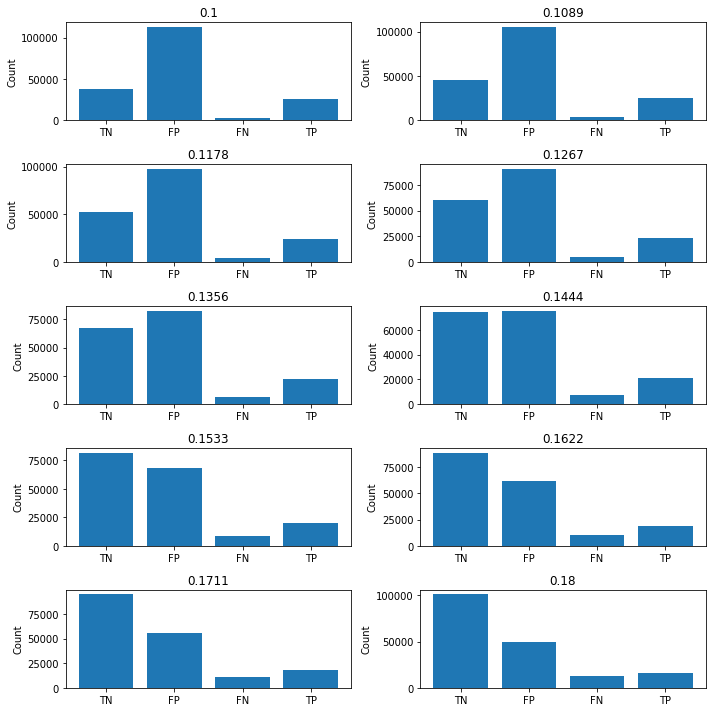

,0.1000,0.1089,0.1178,0.1267,0.1356,0.1444,0.1533,0.1622,0.1711,0.1800
1_real,29075.0000,29075.0000,29075.0000,29075.0000,29075.0000,29075.0000,29075.0000,29075.0000,29075.0000,29075.0000
1_pred,139116.0000,130718.0000,122264.0000,113852.0000,105204.0000,96874.0000,88544.0000,80630.0000,72959.0000,65574.0000
0_real,150302.0000,150302.0000,150302.0000,150302.0000,150302.0000,150302.0000,150302.0000,150302.0000,150302.0000,150302.0000
0_pred,40261.0000,48659.0000,57113.0000,65525.0000,74173.0000,82503.0000,90833.0000,98747.0000,106418.0000,113803.0000
tn,37552.0000,45102.0000,52619.0000,60007.0000,67567.0000,74809.0000,81895.0000,88591.0000,94967.0000,101025.0000
fp,112750.0000,105200.0000,97683.0000,90295.0000,82735.0000,75493.0000,68407.0000,61711.0000,55335.0000,49277.0000
fn,2709.0000,3557.0000,4494.0000,5518.0000,6606.0000,7694.0000,8938.0000,10156.0000,11451.0000,12778.0000
tp,26366.0000,25518.0000,24581.0000,23557.0000,22469.0000,21381.0000,20137.0000,18919.0000,17624.0000,16297.0000
tn_%,20.9000,25.1000,29.3000,33.5000,37.7000,41.7000,45.7000,49.4000,52.9000,56.3000
fp_%,62.9000,58.6000,54.5000,50.3000,46.1000,42.1000,38.1000,34.4000,30.8000,27.5000


In [ ]:
threshold_func(y_val, preds_proba, threshold_list)

### Threshold에 따른 목적함수 값 비교

In [ ]:
OPT_threshold = None
OPT_expected_loss = None
model_name = 'LightGBM'
def objective_func(y_pred_proba, threshold_list):
    
        result_df = pd.DataFrame(index=['1-TPR','FPR','w1_1-TPR','w2_FPR','Expected_loss'])
        
        expected_loss_list = []
        
        for i in range(len(threshold_list)):
            
            threshold = threshold_list[i]
            
            # make Binarizer(y hat)
            binarizer = Binarizer(threshold = threshold).fit(y_pred_proba[:,1].reshape(-1,1))
            custom_predict = binarizer.transform(y_pred_proba[:,1].reshape(-1,1))

            tn, fp, fn, tp = confusion_matrix(y_val, custom_predict).ravel()
            count = [tn, fp, fn, tp]
            
            tpr_1 = fn / (fn + tp)
            fpr = fp / (fp + tn)
            w1 = 0.55
            w2 = 0.45
            
            expected_loss = w1 * tpr_1 + w2 * fpr
            
            expected_loss_list.append(expected_loss)
            
            threshold_tag = round(threshold_list[i], 4)
        
            result_df[threshold_tag] = [tpr_1, fpr, w1*tpr_1, w2*fpr, expected_loss]
            
            if i == 0:
                opt_threshold = threshold
                opt_expected_loss = expected_loss
            else:
                if opt_expected_loss > expected_loss:
                    opt_threshold = threshold
                    opt_expected_loss = expected_loss
                    
#         expected_loss_list = [round(x, 1) for x in expected_loss_list]

        print(opt_threshold)
        print(opt_expected_loss)
        
        plt.plot(threshold_list, expected_loss_list)
        plt.scatter(threshold_list, expected_loss_list)
        
        plt.xlabel('Threshold')
        plt.ylabel('Expected_Loss')
        plt.title('Expected Loss of Thresholds of %s'%(model_name))

        #plt.savefig("%s_expected_loss_%s.png"%(model_name, datetime.datetime.now().strftime("%m%d%H%M%S")), dpi=300, bbox_inches='tight')
        
        plt.show()
        
        global OPT_threshold
        OPT_threshold = opt_threshold
        global OPT_expected_loss
        OPT_expected_loss = opt_expected_loss
        
        #result_df.to_csv('%s_expected_loss_%s.csv'%(model_name, datetime.datetime.now().strftime("%m%d%H%M%S")), float_format='%.3f', index=True)
        
        return result_df

0.14444444444444443
0.3715682204997808


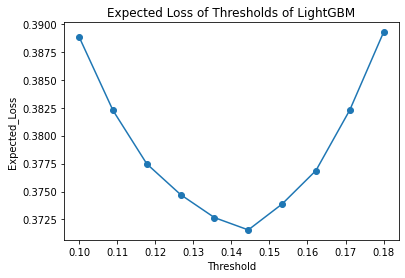

,0.1000,0.1089,0.1178,0.1267,0.1356,0.1444,0.1533,0.1622,0.1711,0.1800
1-TPR,0.093173,0.122339,0.154566,0.189785,0.227206,0.264626,0.307412,0.349304,0.393844,0.439484
FPR,0.750156,0.699924,0.649912,0.600757,0.550458,0.502275,0.455130,0.410580,0.368159,0.327853
w1_1-TPR,0.051245,0.067286,0.085011,0.104382,0.124963,0.145544,0.169077,0.192117,0.216614,0.241716
w2_FPR,0.337570,0.314966,0.292460,0.270341,0.247706,0.226024,0.204809,0.184761,0.165671,0.147534
Expected_loss,0.388815,0.382252,0.377471,0.374722,0.372669,0.371568,0.373885,0.376878,0.382285,0.389250


In [ ]:
objective_func(preds_proba, threshold_list)


In [ ]:
OPT_threshold

0.14444444444444443

### histogram에 optimal threshold 표시


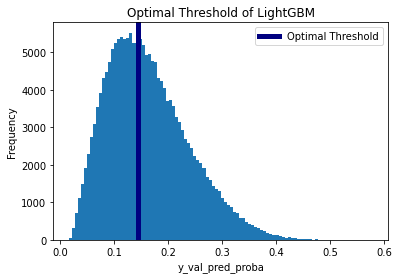

In [ ]:
plt.hist(preds_proba[:,1], bins=100)

plt.axvline(x=OPT_threshold, color='navy', linewidth=5, label='Optimal Threshold')

plt.xlabel('y_val_pred_proba')
plt.ylabel('Frequency')
plt.title('Optimal Threshold of %s'%(model_name))
plt.legend()

#plt.savefig("%s_opt_threshold_%s.png"%(model_name, datetime.datetime.now().strftime("%m%d%H%M%S")), dpi=300, bbox_inches='tight')

plt.show() # y_val_pred_proba의 분포 확인

### test 데이터로 lightGBM 돌려보기

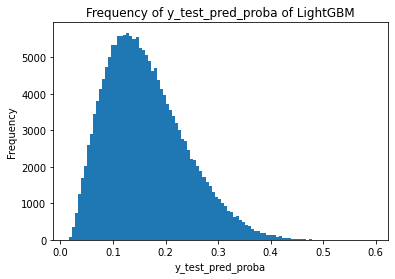

In [ ]:
# Predict probabilities for new data
y_test_pred_proba = lgbm.predict_proba(X_test) # 확률로 추정된 X_test의 y_pred

plt.hist(y_test_pred_proba[:,1], bins=100)

plt.xlabel('y_test_pred_proba')
plt.ylabel('Frequency')
plt.title('Frequency of y_test_pred_proba of %s'%(model_name))

#plt.savefig("%s_test_pre_proba_%s.png"%(model_name, datetime.datetime.now().strftime("%m%d%H%M%S")), dpi=300, bbox_inches='tight')

plt.show() # y_test_pred_proba의 분포 확인

In [ ]:
def test_func(y_test, y_pred_proba, opt_threshold):
        
    # make Binarizer(y hat)
    binarizer = Binarizer(threshold = opt_threshold).fit(y_pred_proba[:,1].reshape(-1,1))
    custom_predict = binarizer.transform(y_pred_proba[:,1].reshape(-1,1))

    # count 0, 1 in Binarizer(y hat)
    unique, counts = np.unique(custom_predict, return_counts=True)

    for val, count in zip(unique, counts):
        if len(unique) == 1:
            if val == 1.0:
                num_0_pred = count
                num_1_pred = 0
            elif val == 0.0:
                num_1_pred = count
                num_0_pred = 0
        if val == 1.0:
            num_0_pred = count
        elif val == 0.0:
            num_1_pred = count

    # count 0, 1 in y hat
    num_1_real = y_test.value_counts()[0]
    num_0_real = y_test.value_counts()[1]

    tn, fp, fn, tp = confusion_matrix(y_test, custom_predict).ravel()
    count = [tn, fp, fn, tp]
    tn_, fp_, fn_, tp_ = [round(x/sum(count)*100, 1) for x in count]

    accuracy = round((tp+tn)/(tp+tn+fp+fn),4)
    precision = round(tp/(tp+fp),4)
    recall = round(tp/(tp+fn),4)
    f1 = round(2*(precision*recall)/(precision+recall),4)
    
    result_df = pd.DataFrame(index=['1_real','1_pred','0_real','0_pred','tn', 'fp', 'fn', 'tp', 'tn_%', 'fp_%', 'fn_%', 'tp_%', 'Accuracy', 'Precision', 'Recall', 'F1 score'])

    result_df['result'] = [num_1_real, num_1_pred, num_0_real, num_0_pred, tn, fp, fn, tp, tn_, fp_, fn_, tp_, accuracy, precision, recall, f1]

    labels = ['TN','FP','FN','TP']


    # 혼동 행렬 시각화
    labels = ['Positive', 'Negative']
    cm = [[tp, fn], [fp, tn]]

    ax = plt.subplot()
    sns.heatmap(cm, annot=True, ax=ax, fmt='g', cmap='Blues')
    ax.set_xlabel('Predicted Class')
    ax.set_ylabel('Acutual Class')
    ax.set_xticklabels(labels)
    ax.set_yticklabels(labels)
    ax.set_title('%s Confusion Matrix'%(model_name))
    
    ax.text(0.45, 1.40, 'FP', fontsize=12, color='red')
    ax.text(1.45, 1.40, 'TN', fontsize=12, color='red')
    ax.text(0.45, 0.40, 'TP', fontsize=12, color='red')
    ax.text(1.45, 0.40, 'FN', fontsize=12, color='red')
    
    #plt.savefig("%s_Confusion_Matrix_%s.png"%(model_name, datetime.datetime.now().strftime("%m%d%H%M%S")), dpi=300, bbox_inches='tight')
    plt.show()
    
    #result_df.T.to_csv('%s_test.csv'%(model_name), index=True)

    return result_df.T

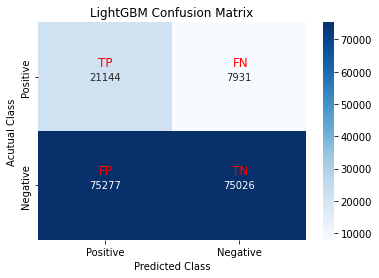

,1_real,1_pred,0_real,0_pred,tn,fp,fn,tp,tn_%,fp_%,fn_%,tp_%,Accuracy,Precision,Recall,F1 score
result,150303.0,82957.0,29075.0,96421.0,75026.0,75277.0,7931.0,21144.0,41.8,42.0,4.4,11.8,0.5361,0.2193,0.7272,0.337


In [ ]:
test_func(y_test, y_test_pred_proba, OPT_threshold)

In [ ]:
def test_objective_func(y_test, y_pred_proba, threshold):
    
        result_df = pd.DataFrame(index=['1-TPR','FPR','w1_1-TPR','w2_FPR','Expected_loss'])
            
        # make Binarizer(y hat)
        binarizer = Binarizer(threshold = threshold).fit(y_pred_proba[:,1].reshape(-1,1))
        custom_predict = binarizer.transform(y_pred_proba[:,1].reshape(-1,1))

        tn, fp, fn, tp = confusion_matrix(y_test, custom_predict).ravel()
        count = [tn, fp, fn, tp]

        tpr_1 = fn / (fn + tp)
        fpr = fp / (fp + tn)
        w1 = 0.55
        w2 = 0.45

        expected_loss = w1 * tpr_1 + w2 * fpr

        result_df[threshold] = [tpr_1, fpr, w1*tpr_1, w2*fpr, expected_loss]

        print(expected_loss)
        
        result_df.T.to_csv('%s_test_expected_loss_%s.csv'%(model_name, datetime.datetime.now().strftime("%m%d%H%M%S")), float_format='%.6f', index=True)
        
        return result_df

In [ ]:
test_objective_func(y_test, y_test_pred_proba, OPT_threshold)

0.3754032560504651


,0.144444
1-TPR,0.272777
FPR,0.500835
w1_1-TPR,0.150028
w2_FPR,0.225376
Expected_loss,0.375403


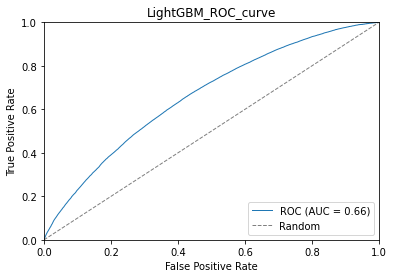

In [ ]:
# Generate ROC curve and AUC score for the test set
fpr, tpr, thresholds = roc_curve(y_test, y_test_pred_proba[:,1])
roc_auc = auc(fpr, tpr)

# Plot the ROC curve
plt.plot(fpr, tpr, lw=1, label='ROC (AUC = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], '--', color='gray', lw=1, label='Random')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('%s_ROC_curve'%(model_name))
plt.legend(loc='lower right')

plt.savefig("%s_ROC_curve_%s.png"%(model_name, datetime.datetime.now().strftime("%m%d%H%M%S")), dpi=300, bbox_inches='tight')
plt.show()